# Does Boarding Cost Millions?

Basic commercial aviation economics states that a plane on the ground is a plane that does not make money. Therefore, the turn-around time on the ground is aimed to be cut as short as possible. For one-row airliners that fly mainly short-haul,  but also medium haul flights, this turn-around time is aimed to be between 30 to 45 minutes at the gate. This include the deplaining (the arriving passengers exiting the plane), cleaning and crew exchange, and the enplaining (the departing passengers entering the plane). By far, the longest of these three processes is the enplaining. But why? This has several reasons. While many passengers, especially on short-haul flights prefer carry-on luggage to avoid waiting at luggage belts for their suitcases, these need to be stowed in the top cabinets of the plane, which takes time. The largest culprit, however, is the current order of boarding groups being brought onto the plane. Most commonly, the order goes: people needing assistance, certain status members for the airline's alliance, first class, busines class, economy class (often split up into additional groups). Generally, it can be said that it is a front-to-back procedure. This is a recipe for a traffic jam. Leaving aside people needing additional assistance, as they should be given all time that they need to board the plane, after that, the front-row people take time to get situated in their seat. While they get situated, the queue backs up through the gate into the terminal building. While the different boarding groups is aiming to mitigate the physical line being overly long right from the beginning, the system is simply illogical in terms of efficiency. 

And while airlines presumably are not adapting their boarding procedure in order to maintain the priority status of status members and first/business class passengers, airlines could save approximately 30 USD per minute of faster turn-around time. Considering an airline with 5,000 flights/year, and just reducing the turn-around time by one minute, that would be a saving of about 50 million USD (Jaehn & Neumann, 2015)! Additionally, the sum of the time saving would open up additional planes as resource for additional destinations, and allow for increased passanger capacity. This is important especially in the 2020s, with highest air travel volume ever recorded, and increasingly cluttered and busy airports, runways and airspaces. Especially the limited amount of slots in the airspaces is an important consideration, especially in relation to air safety, and the already overload of air traffic controllers around the world. If interested, this video provides an excellent summary of how many people, especially ATCs, are involved in even short-haul routine flights (https://www.youtube.com/watch?v=C1f2GwWLB3k)

In order to further understand how many resources could be saved, this project aims to simulate a back-to-front boarding order. It should be noted, that every plane has a door in the back, that hypothecially could be reached by the gate's arm, allowing the priority passenger to still board first, except that they need to walk a bit further. Using the back-to-front method, the passengers will not be in such a long queue, because the back will start to fill up first. 

Using the simulation package Simpy in Python, both methods, back-to-front and the classic front-to-back, are simulated and compared in their total enplaining time. 
In this simulation, a Lufthansa A320-neo with 180 seats is assumed. The A320-neo is short-haul plane, used all around the world for this purpose. It is a newer plane, with inital launch in 2016, but increasing orders due to its fuel efficiency. This specific model is used for routes between, for example, Stuttgart to Berlin, Frankfurt to London, or Hamburg to Madrid. Below figure is depicting the plane's seat map and also visualizing both boarding techniques.



## Simulation Variables Set-Up

Below code will load the necessary libraries and set up the variables for the simulation. As can be seen in the seat map, the 180 total passengers are divided onto 32 rows of seats with 6 seats per row, except business class, which has only 4 seats per row, for the first 7 rows. Additionally, there are four boarding groups with 8 rows each. Lastly, the time for passengers to finish the boarding process is derived from a random number generator based on a normal distribution with a mean of 3 minutes and standard deviaiton of 15 seconds. Because some passengers are faster than others, some do not have carry-on luggage, and many other considerations impact the time for each passanger individually. 
The cabin capacity must also be tracked, because it matters in which direction the plane is boarded. Assuming a passenger requires about 1m2 of space, and the A320 has a cabin length of 32m, the maximum capacity can easily be 27, estimated conservatively.

In [1]:
import simpy
import random
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(1010) #Set seed for reproducibility

TOTAL_ROWS = 32
BUSINESS_CLASS_ROWS = 7
BUSINESS_CLASS_SEATS_PER_ROW = 4
ECONOMY_CLASS_ROWS = TOTAL_ROWS - BUSINESS_CLASS_ROWS
ECONOMY_CLASS_SEATS_PER_ROW = 6
BOARDING_GROUP_SIZE = 4  # Number of rows in each boarding group
MAX_CABIN_CAPACITY = 27  # Maximum number of passengers in the cabin at once
INITIAL_CABIN_CAPACITY = 6  # Initial cabin capacity for front-to-back boarding

# Boarding time constants
INTER_ARRIVAL_TIME = 0.15  # Average time between passenger arrivals (in minutes, ~10 seconds = 0.15 minutes)
BOARDING_TIME_MEAN = 2  # Mean time taken to board and stow luggage (in minutes)
BOARDING_TIME_STD_DEV = 0.25   # Standard deviation of boarding time (in minutes, 15 seconds = 0.25 minutes)


## Simulation Processes
The following code will use Simpy to set up the simulation. A class named Plane is defined, which is the overall object wherein the simulation occurs. Within this object, variables to log the process are defined, such as total boarding time, cabin occupancy, baorded rows and the capacity. These are all important to track the boarding process. Next, the passenger is defined. The passenger's behavior is modeled as follows: arrive at the gate, board the plane, and stow the luggage, based on a stochastic process from a random number generator from a Gaussian distribution. For Simpy to take this into account, the passenger needs to yield (i.e., wait) and request entering the boarding process. Then, the boarding time is sampled from the stoachstic process (in this case, average 2 minutes with an SD of 15 seconds). The passenger is made to yield also for this time. For logging, the total boarding time is tracked as well as the current cabin occupancy. After the passenger, the cabin capacity is tracked. As defined above, this is important for this simulation, and the code simply computed the new capacity based on which row is currently boarding.  
Now, the two large and complex processes of boarding back-to-front and front-to-back are defined. At first, the cabin capacity is defined, either the maximum, for back-to-front, because the cabin can fill up immediately, or the initial capacity for front-to-back. Then, either economy or business class (depending the process) starts boarding. Here, the starting row is first determined, followed by the specific seat in the row. The passengers are yielding until there is space in the cabin, and then enter it. Once it's their turn, they will complete the boarding process based on the stochastic generator. **The important consideration here is the length of the queue time to get started with the boarding process!**
Once the passenger has the boarding completed, the capacity is tracked in order to let the next passenger enter the cabin.  
While the back-to-front boarding process let's the economy class start first, it is theoretically possible to have the first/business class board first and have them enter from the back of the plane. This would yield the same results. For the front-to-back process, it is of course business boarding first, which leads to longer wait times to start boarding due to the back-log.

In [2]:
class Plane:
    def __init__(self, env, initial_capacity=MAX_CABIN_CAPACITY):
        self.env = env
        self.cabin_capacity = initial_capacity
        self.boarding_process = simpy.Resource(env, capacity=self.cabin_capacity)
        self.total_boarding_time = []
        self.cabin_occupancy = 0
        self.boarded_rows = 0
        self.occupancy_over_time = []

    def passenger(self, name, row):
        """A passenger arrives at the gate, boards the plane, and stows luggage."""
        arrive = self.env.now
        with self.boarding_process.request() as request:
            yield request
            boarding_time = max(0, random.gauss(BOARDING_TIME_MEAN, BOARDING_TIME_STD_DEV))
            yield self.env.timeout(boarding_time)
            self.total_boarding_time.append(self.env.now)
            self.cabin_occupancy -= 1
            self.occupancy_over_time.append((self.env.now, self.cabin_occupancy))

    def update_cabin_capacity(self, new_capacity):
        """Update the cabin capacity and resource if capacity changes."""
        self.cabin_capacity = new_capacity
        self.boarding_process = simpy.Resource(self.env, capacity=self.cabin_capacity)

    def generate_passengers_back_to_front(self):
        """Generate passengers according to the back-to-front boarding process."""
        current_capacity = MAX_CABIN_CAPACITY
        self.update_cabin_capacity(current_capacity)

        # Economy Class
        for group in range(ECONOMY_CLASS_ROWS // BOARDING_GROUP_SIZE, 0, -1):
            start_row = BUSINESS_CLASS_ROWS + (group - 1) * BOARDING_GROUP_SIZE
            end_row = BUSINESS_CLASS_ROWS + group * BOARDING_GROUP_SIZE
            for row in range(start_row, end_row):
                for seat in range(ECONOMY_CLASS_SEATS_PER_ROW):
                    while self.cabin_occupancy >= current_capacity:
                        yield self.env.timeout(1)  # Wait until there is space in the cabin
                    self.cabin_occupancy += 1
                    self.occupancy_over_time.append((self.env.now, self.cabin_occupancy))
                    passenger_name = f'Passenger {row}-{seat}'
                    self.env.process(self.passenger(passenger_name, row))
                    yield self.env.timeout(random.expovariate(1.0 / INTER_ARRIVAL_TIME))
                self.boarded_rows += 1
                if self.boarded_rows % ECONOMY_CLASS_SEATS_PER_ROW == 0:
                    current_capacity = max(current_capacity - 1, INITIAL_CABIN_CAPACITY)
                    self.update_cabin_capacity(current_capacity)

        # Business Class
        for row in range(BUSINESS_CLASS_ROWS - 1, -1, -1):
            for seat in range(BUSINESS_CLASS_SEATS_PER_ROW):
                while self.cabin_occupancy >= current_capacity:
                    yield self.env.timeout(1)  # Wait until there is space in the cabin
                self.cabin_occupancy += 1
                self.occupancy_over_time.append((self.env.now, self.cabin_occupancy))
                passenger_name = f'Passenger {row}-{seat}'
                self.env.process(self.passenger(passenger_name, row))
                yield self.env.timeout(random.expovariate(1.0 / INTER_ARRIVAL_TIME))

    def generate_passengers_front_to_back(self):
        """Generate passengers according to the front-to-back boarding process."""
        # Business Class
        current_capacity = INITIAL_CABIN_CAPACITY
        self.update_cabin_capacity(current_capacity)
        for row in range(BUSINESS_CLASS_ROWS):
            for seat in range(BUSINESS_CLASS_SEATS_PER_ROW):
                while self.cabin_occupancy >= current_capacity:
                    yield self.env.timeout(1)  # Wait until there is space in the cabin
                self.cabin_occupancy += 1
                self.occupancy_over_time.append((self.env.now, self.cabin_occupancy))
                passenger_name = f'Passenger {row}-{seat}'
                self.env.process(self.passenger(passenger_name, row))
                yield self.env.timeout(random.expovariate(1.0 / INTER_ARRIVAL_TIME))

        # Economy Class
        for group in range(ECONOMY_CLASS_ROWS // BOARDING_GROUP_SIZE):
            start_row = BUSINESS_CLASS_ROWS + group * BOARDING_GROUP_SIZE
            end_row = BUSINESS_CLASS_ROWS + (group + 1) * BOARDING_GROUP_SIZE
            for row in range(start_row, end_row):
                for seat in range(ECONOMY_CLASS_SEATS_PER_ROW):
                    while self.cabin_occupancy >= current_capacity:
                        yield self.env.timeout(1)  # Wait until there is space in the cabin
                    self.cabin_occupancy += 1
                    self.occupancy_over_time.append((self.env.now, self.cabin_occupancy))
                    passenger_name = f'Passenger {row}-{seat}'
                    self.env.process(self.passenger(passenger_name, row))
                    yield self.env.timeout(random.expovariate(1.0 / INTER_ARRIVAL_TIME))
                self.boarded_rows += 1
                if self.boarded_rows % ECONOMY_CLASS_SEATS_PER_ROW == 0:
                    current_capacity = min(current_capacity + 1, MAX_CABIN_CAPACITY)
                    self.update_cabin_capacity(current_capacity)


## Execute Simulation
The following code executes the simulation. First, a function to run the simulation is defined. This allows for flexible choice of boarding method, and would even allow to extend the boarding processes to other ideas as well. Then, a function to run multiple simulation is defined. Due to the stoachstic nature of the boarding time, and in order to conduct hypothesis tests, simulating each boarding process multiple times is worthwhile.  
Subsequently, each boarding process is simulated 1000 times. The results are saved and aggregated to analyze the final results in the next bracket.

In [3]:
def run_simulation(generate_passengers_method):
    """Runs the simulation with the given passenger generation method."""
    # Create the environment and the plane object
    env = simpy.Environment()
    plane = Plane(env)

    # Start the passenger generation process
    env.process(generate_passengers_method(plane))

    # Run the simulation
    env.run()

    # Calculate the total boarding time
    if plane.total_boarding_time:
        total_time = max(plane.total_boarding_time)
    else:
        total_time = None

    return total_time, plane.occupancy_over_time

def run_multiple_simulations(generate_passengers_method, num_runs):
    """Runs multiple simulations and returns the aggregated results."""
    results = []
    occupancy_over_time_runs = []
    for _ in range(num_runs):
        total_time, occupancy_over_time = run_simulation(generate_passengers_method)
        if total_time is not None:
            results.append(total_time)
            occupancy_over_time_runs.append(occupancy_over_time)
    return results, occupancy_over_time_runs

# Run multiple simulations for back-to-front and front-to-back boarding
num_runs = 1000 
btf_results, btf_occupancy_over_time_runs = run_multiple_simulations(Plane.generate_passengers_back_to_front, num_runs)
ftb_results, ftb_occupancy_over_time_runs = run_multiple_simulations(Plane.generate_passengers_front_to_back, num_runs)

# Calculate statistics
btf_mean = np.mean(btf_results)
btf_std_dev = np.std(btf_results)
ftb_mean = np.mean(ftb_results)
ftb_std_dev = np.std(ftb_results)

## Simulation Results
The code below prints the average (and SDs) minutes for each boarding process, based on the 1000 iterations. Additionally, a time-series of the cabin occupancy is plotted, as this is one of the main drivers of the boarding time. This time-series shows only one sample of each boarding process, however, and not the aggregate.

Back-to-Front Boarding Results:
Mean Total Boarding Time: 27.92 minutes
Standard Deviation: 1.87 minutes

Front-to-Back Boarding Results:
Mean Total Boarding Time: 64.34 minutes
Standard Deviation: 1.21 minutes


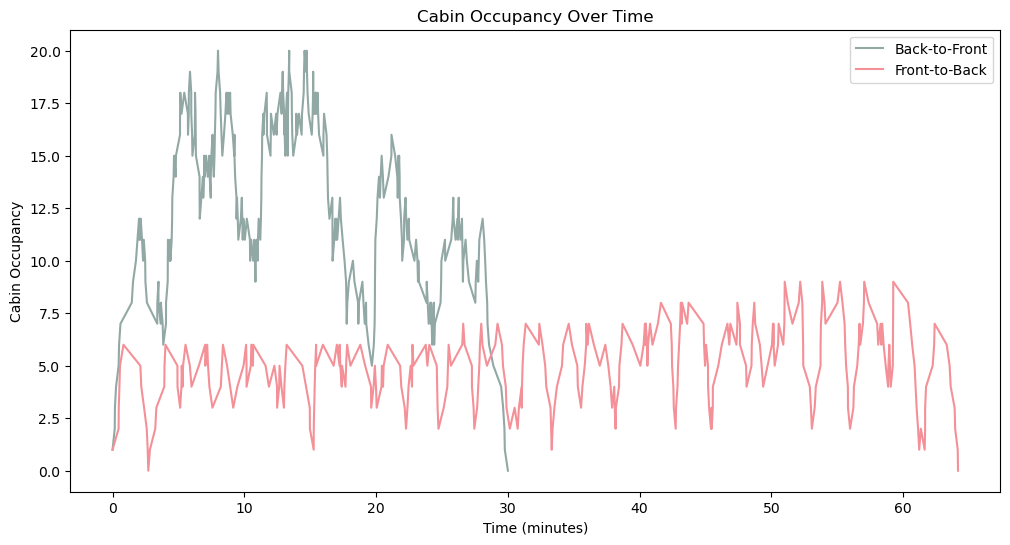

In [4]:
print("Back-to-Front Boarding Results:")
print(f'Mean Total Boarding Time: {btf_mean:.2f} minutes')
print(f'Standard Deviation: {btf_std_dev:.2f} minutes')

print("\nFront-to-Back Boarding Results:")
print(f'Mean Total Boarding Time: {ftb_mean:.2f} minutes')
print(f'Standard Deviation: {ftb_std_dev:.2f} minutes')

# Plot time series of cabin occupancy for a single run (for illustration)
def plot_cabin_occupancy(occupancy_over_time, method_label, color):
    times, occupancies = zip(*occupancy_over_time)
    plt.plot(times, occupancies, label=method_label, color = color)

# Plot a single run from each method
plt.figure(figsize=(12, 6))
plot_cabin_occupancy(btf_occupancy_over_time_runs[0], 'Back-to-Front', '#91A8A4')
plot_cabin_occupancy(ftb_occupancy_over_time_runs[0], 'Front-to-Back', '#F49097')
plt.title('Cabin Occupancy Over Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Cabin Occupancy')
plt.legend()
plt.show()

## Statistical Analysis
In order to fully understand the impact of changing the boarding process from front-to-back to back-to-front, a two-samples *t*-test is performed based on the distribtuions of the simulations. The result indicated the the back-to-front process is significantly faster compared to the front-to-back process (*t*[1998] = -516.78, *p* < 0.001). Considering the time-series of cabin occupancy above, it is likely that this difference is due to the much higher possible cabin occupancy in the back-to-front process, which speeds up the process in the aggregate.

In [5]:
btf_results_arr = np.array(btf_results) #Compute numpy array
ftb_results_arr = np.array(ftb_results) #Compute numpy array

t_test= stats.ttest_ind(btf_results_arr, ftb_results_arr)
t_stat = t_test.statistic
p_value = t_test.pvalue
df = t_test.df

print('T-Value: ', t_stat)
print('df: ', df)
print('p-value: ', p_value)

T-Value:  -516.7798692298464
df:  1998.0
p-value:  0.0


## Visualization
Lastly, additional vsiualizations can be added for support of the statistical findings. Firstly, a violin/boxplot combination allows for between-group comparison of the simulation outcomes. It is clearly apparent that the back-to-front is faster than the front-to-back method.  
Additionally, histograms of each simulation distribution are plotted to depict the normal distriubtion of each. This also warrants the use of the *t*-test. 

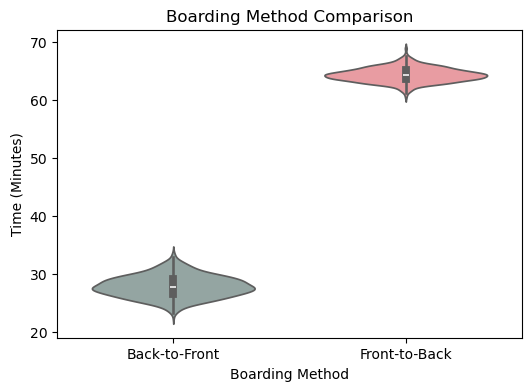

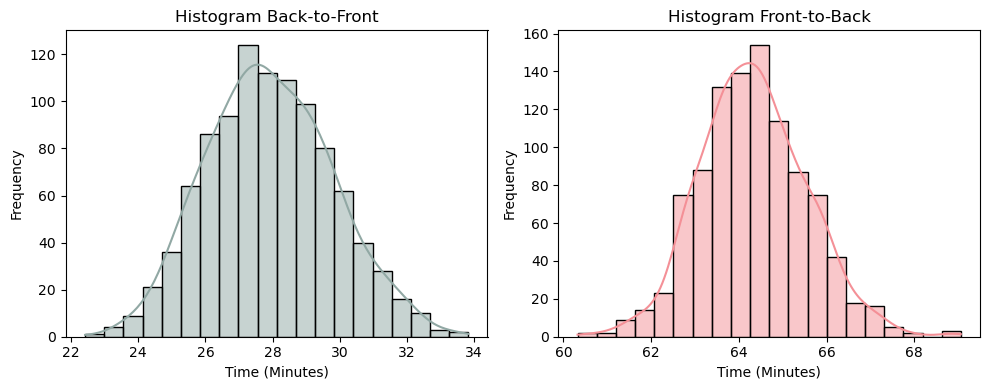

In [6]:
# Violin plot
plt.figure(figsize=(6, 4))
sns.violinplot(data=[btf_results_arr, ftb_results_arr], palette=['#91A8A4', '#F49097'], width=0.7)
plt.title('Boarding Method Comparison')
plt.xlabel('Boarding Method')
plt.ylabel('Time (Minutes)')
plt.xticks([0, 1], ['Back-to-Front', 'Front-to-Back'])
plt.show()

#Histograms
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(btf_results_arr, bins=20, kde=True, color='#91A8A4', label='Data 1')
plt.title('Histogram Back-to-Front')
plt.xlabel('Time (Minutes)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(ftb_results_arr, bins=20, kde=True, color='#F49097', label='Data 2')
plt.title('Histogram Front-to-Back')
plt.xlabel('Time (Minutes)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


## Verification and Validation

The model that verified by assuring the code runs properly. This was done by adapting the constant variables with extreme variables (i.e., no passengers). This deemed the model to be verified.  
Validation was done by comparing to previously published literature. There is a strong consensus that the back-to-front row is superior (Allon, 2023; Cotfas et al., 2020)

## Conclusion
This project aimed to test whether changing the boarding process in commercial air travel can lead to faster turn-around times. The result is clear: utilizing a back-to-front method, where people can fill up the cabin right away and maintain this level, allows to cut the boarding time in half (50%) from, on average, 63 minutes to 28 minutes. This is not only more comfortable for passengers, but putting translaing this into money, it would save an airline 900 USD per flight, on average. Estimating this, an airline with 5,000 flights/year could save approximately 4.5 million USD, and 150,000 minutes, or 2,500 hours. This is significant, not only because of the savings in money, but this could allow airlines to increase their flights without having to purchase more aircraft. While in recent years, some airlines have opted for the faster window-to-aisle boarding method (Stawski & Amond, 2024), making way of the prioity nonsense and boarding back-to-front will simply be the most efficient way. The plane will not leave until the boarding process is completed, therefore, whether people wait in the gate, in the queue, or in their seat, the wait time is the same for everyone. In similar fashion, a car speeding toward a red light will need to wait the same amount of time than a car that rolls to a red light.

## References
Allon (2023). Rethinking Airplane Boarding: Balancing Efficiency, Preferences, and Real-World Complexities. https://gadallon.substack.com/p/rethinking-airplane-boarding-balancing  
Cotfas, Delcea, Milne, Salari (2020). Evaluating Classical Airplane Boarding Methods Considering COVID-19 Flying Restrictions. *Symmetry*. doi.org/10.3390/sym12071087  
Jaehn & Neumann (2018). Airplane Boarding. *European Journal of Operational Research*. 10.1016/j.ejor.2014.12.008  
Stawski & Amond (2024). United to prioritize window seat boarding — but your credit card can still help you board early. *CNBC*. https://www.cnbc.com/select/united-boarding-process-prioritize-window-seats/